# Melanoma Detection Assignment
Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
# Importing required libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling, BatchNormalization
from keras.models import Sequential
import glob, shutil
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

#### Importing Skin Cancer Data

In [2]:
# mounting google drive directory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# changing directory to target directory
os.chdir('/content/drive/My Drive/Colab Notebooks/')

In [4]:
# checking the present directory
!pwd

/content/drive/My Drive/Colab Notebooks


In [5]:
# checking the list of files and folders in the present directory
!ls -l

total 804839
-rw------- 1 root root     20474 Jul 12 19:00 Anik_Nath_nn.ipynb
-rw------- 1 root root     85220 Jul 10 13:51 Cifar10_l2_notebook.ipynb
-rw------- 1 root root     88073 Jul 10 13:37 Cifar_10_notebook.ipynb
-rw------- 1 root root     84112 Jul 10 13:16 Cifar_10_Notebook_with_BN_without_dropout.ipynb
-rw------- 1 root root     80476 Jul 10 12:57 Cifar_10_with_dropout_without_BN.ipynb
drwx------ 2 root root      4096 Jul 12 17:51 CNN_Assignment
-rw------- 1 root root 823790659 Jul 11 11:45 CNN_assignment.zip


In [6]:
# removing the CNN_Assignment dir if it exists
! rm -rf CNN_Assignment
# unzipping the dataset zip file
!unzip -q "/content/drive/My Drive/Colab Notebooks/CNN_assignment.zip"

In [7]:
# checking the list of files and folders in the present directory again
!ls -l

total 804841
-rw------- 1 root root     22295 Jul 12 19:02  Anik_Nath_nn.ipynb
-rw------- 1 root root     85220 Jul 10 13:51  Cifar10_l2_notebook.ipynb
-rw------- 1 root root     88073 Jul 10 13:37  Cifar_10_notebook.ipynb
-rw------- 1 root root     84112 Jul 10 13:16  Cifar_10_Notebook_with_BN_without_dropout.ipynb
-rw------- 1 root root     80476 Jul 10 12:57  Cifar_10_with_dropout_without_BN.ipynb
-rw------- 1 root root 823790659 Jul 11 11:45  CNN_assignment.zip
drwx------ 4 root root      4096 Jul 12 19:03 'Skin cancer ISIC The International Skin Imaging Collaboration'


In [8]:
# renaming the extracted dataset directory
!mv 'Skin cancer ISIC The International Skin Imaging Collaboration' 'CNN_Assignment'

In [9]:
# checking the list of files and folders in the present directory again
!ls -l

total 804841
-rw------- 1 root root     22295 Jul 12 19:02 Anik_Nath_nn.ipynb
-rw------- 1 root root     85220 Jul 10 13:51 Cifar10_l2_notebook.ipynb
-rw------- 1 root root     88073 Jul 10 13:37 Cifar_10_notebook.ipynb
-rw------- 1 root root     84112 Jul 10 13:16 Cifar_10_Notebook_with_BN_without_dropout.ipynb
-rw------- 1 root root     80476 Jul 10 12:57 Cifar_10_with_dropout_without_BN.ipynb
drwx------ 4 root root      4096 Jul 12 19:03 CNN_Assignment
-rw------- 1 root root 823790659 Jul 11 11:45 CNN_assignment.zip


In [10]:
# changing present directory to the dataset directory
os.chdir('CNN_Assignment/')
!pwd

/content/drive/My Drive/Colab Notebooks/CNN_Assignment


In [11]:
# checking the list of files and folders in the present directory
!ls -l

total 8
drwx------ 11 root root 4096 Jul 12 19:03 Test
drwx------ 11 root root 4096 Jul 12 19:03 Train


In [12]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path("Test")

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [13]:
# validating the number of images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Create Train and Validation Dataset
Splitting the Train dataset, to use 80% of the images for training, and 20% for validation.

In [14]:
# Splitting into train and validation dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Visualising the datasets
Visualising one image from each of the nine classes

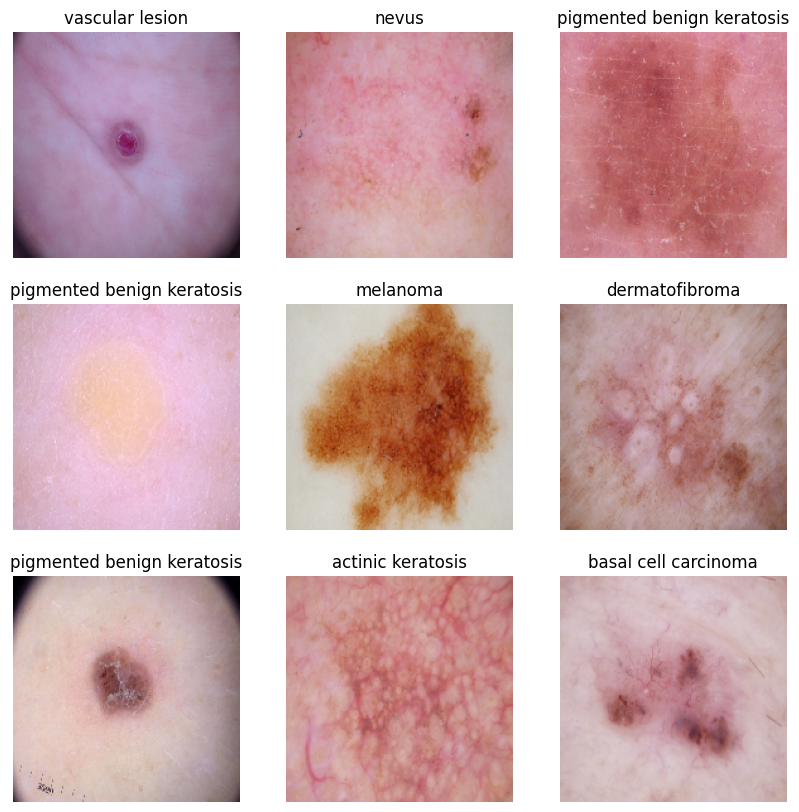

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.imshow(images[i].numpy().astype("uint8"))

#### Preparing datasets for Modelling

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Rescaling the Dataset

In [18]:
rescale = Rescaling(scale=1./255)

norm_train_ds = train_ds.map(lambda x, y: (rescale(x), y))
norm_val_ds = val_ds.map(lambda x, y: (rescale(x), y))

#### Model 1
Basic CNN model, which can accurately detect 9 classes present in the dataset.

In [19]:
# model architecture
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('softmax'))

In [20]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 90, 90, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

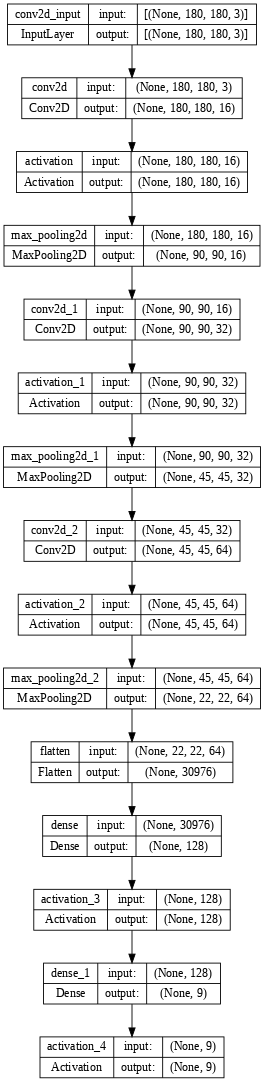

In [21]:
# visualising the network
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [22]:
# compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# training the model
epochs=20
history = model.fit(norm_train_ds,validation_data=norm_val_ds,epochs=epochs)

Epoch 1/20
56/56 [==============================] - 32s 120ms/step - loss: 2.0462 - accuracy: 0.2506 - val_loss: 2.0306 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6859 - accuracy: 0.3990 - val_loss: 1.6014 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5017 - accuracy: 0.4844 - val_loss: 1.5056 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4050 - accuracy: 0.5218 - val_loss: 1.4647 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2704 - accuracy: 0.5536 - val_loss: 1.3376 - val_accuracy: 0.5615
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2054 - accuracy: 0.5770 - val_loss: 1.4152 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1271 - accuracy: 0.5960 - val_loss: 1.3248 - val_accuracy: 0.5436
Epoch 8/20


In [24]:
# function to visualise the results
def visualise(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

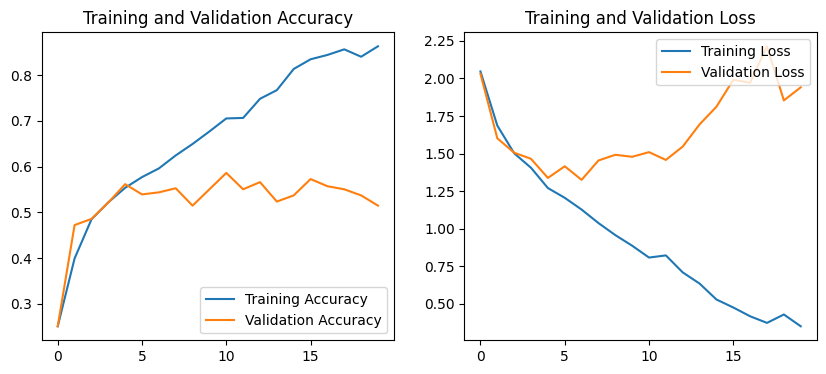

In [25]:
# visualising the results
visualise(history)

__Findings:__ From the graph we can see training accuracy is very high as compared to validation accuracy. We can also see difference in loss functions in training and validation data. This is a clear case of overfitting where model has learned too much from training dataset and it is not able to perform well on the validation dataset.

#### Data Augmentation to resolve overfitting

In [26]:
# Convert _PrefetchDataset to NumPy arrays
X_train = tf.concat([x for x, _ in train_ds], axis=0)
y_train = tf.concat([y for _, y in train_ds], axis=0)

X_test = tf.concat([x for x, _ in val_ds], axis=0)
y_test = tf.concat([y for _, y in val_ds], axis=0)

# Normalize the pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

In [27]:
# Defining the imagedatagenerator for train and test image for pre-processing
# We don't give horizonal_flip or other preprocessing for validation data generator

image_size = 180
batch_size = 32

train_data_gen = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, rotation_range=30)
# valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
augmented_data = train_data_gen.flow(X_train, y_train, batch_size=batch_size)

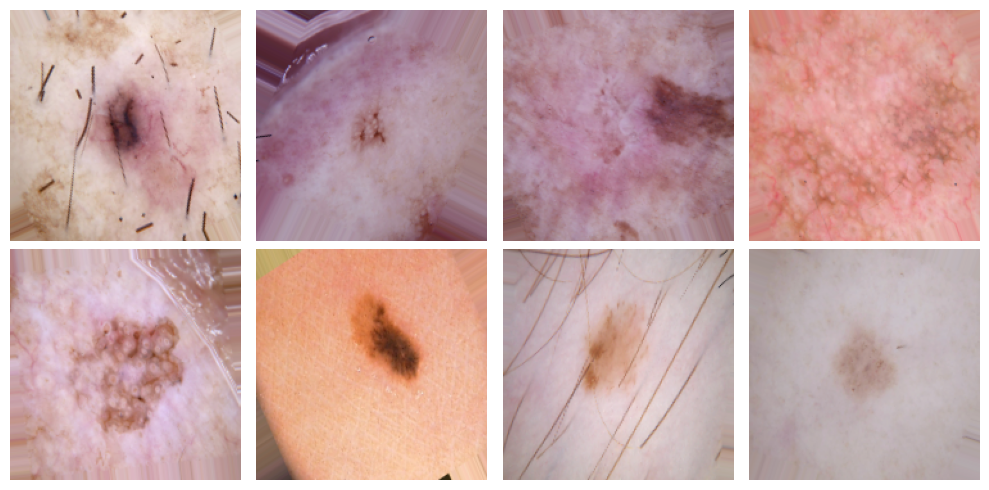

In [28]:
# Plot the augmented images
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i in range(2):
    for j in range(4):
        augmented_images, _ = augmented_data.next()
        augmented_images = augmented_images[0] * 255.0  # Scale pixel values back to [0, 255] for visualisation
        axs[i, j].imshow(augmented_images.astype('uint8'))
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

#### Model 2 - After Augmentation
We will use dropout layer as the previous model was overfitting in our findings.

In [29]:
# model architecture
model2 = Sequential()
model2.add(Conv2D(16, (3, 3), padding='same', input_shape=(180,180,3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(32, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D())

model2.add(Dropout(0.15))

model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dense(9))
model2.add(Activation('softmax'))

In [30]:
# model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_5 (Activation)   (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 activation_6 (Activation)   (None, 90, 90, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [31]:
# compiling the model
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
# training the model
epochs=20
history2 = model2.fit(augmented_data, validation_data=norm_val_ds, epochs=epochs, verbose=1)

Epoch 1/20
56/56 [==============================] - 16s 235ms/step - loss: 2.0873 - accuracy: 0.1814 - val_loss: 2.0292 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 13s 223ms/step - loss: 2.0264 - accuracy: 0.1975 - val_loss: 2.0501 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 14s 241ms/step - loss: 2.0354 - accuracy: 0.1953 - val_loss: 2.0693 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 14s 244ms/step - loss: 2.0215 - accuracy: 0.2015 - val_loss: 2.0380 - val_accuracy: 0.1991
Epoch 5/20
56/56 [==============================] - 14s 242ms/step - loss: 2.0295 - accuracy: 0.1892 - val_loss: 2.0317 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 13s 239ms/step - loss: 2.0214 - accuracy: 0.2037 - val_loss: 2.0299 - val_accuracy: 0.2013
Epoch 7/20
56/56 [==============================] - 13s 235ms/step - loss: 2.0181 - accuracy: 0.2009 - val_loss: 2.0304 - val_accuracy: 0.1946

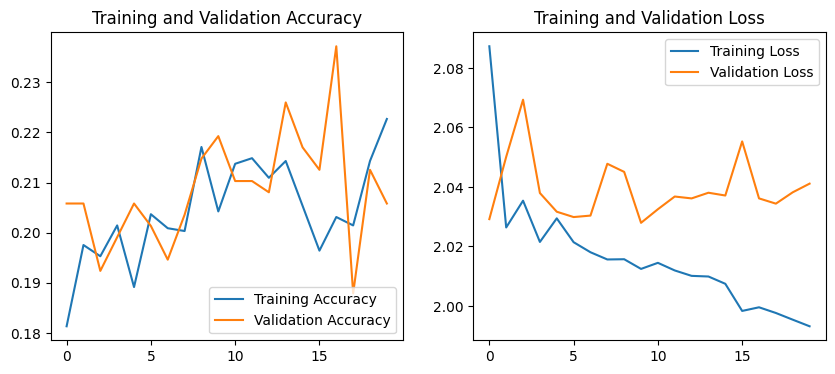

In [33]:
# visualising the results
visualise(history2)

__Findings:__ Accuracy of trainings has not improved as compared to base model. Also validation accuracy is increased slightly compared to base model. We observe that overfitting issue has been reduced due to data augmentation. We observe the current model is underfitting.

#### Class Distribution

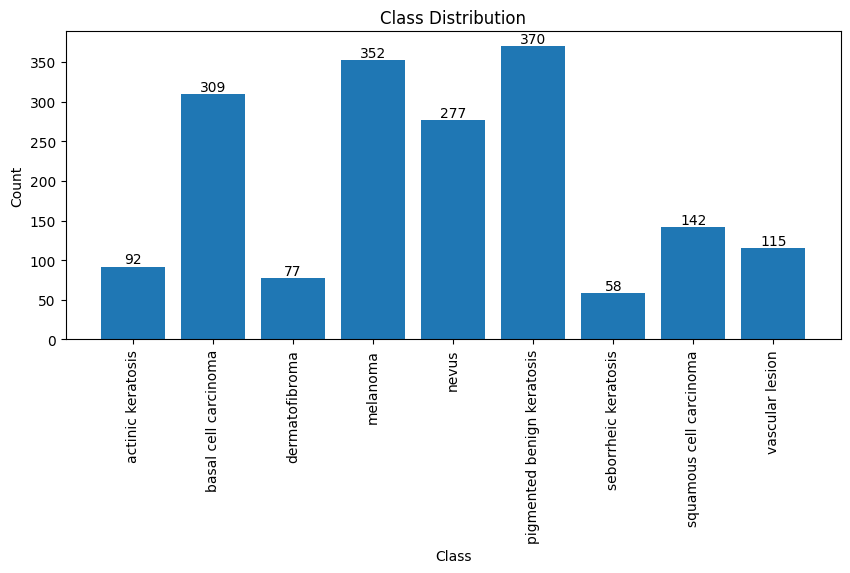

In [34]:
# Get unique class labels and their counts
classes, counts = np.unique(y_train, return_counts=True)
# Create a bar plot
plt.figure(figsize=(10,4))
plt.bar(class_names, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Class Distribution')
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

__Findings:__ Looks like the class "seborrheic keratosis" has the least number of samples. Whereas, the class "
pigmented benign keratosis" has the highest number of samples, followed by "melanoma". Therefore, there is an imbalance in the class distribution, which needs to be resolved.

#### Handling Class Imbalance

In [35]:
# installing and importing Augmentor
!pip install Augmentor
import Augmentor

In [36]:
# using Augmentor to resolve class imbalance
path_to_training_dataset = str(data_dir_train)+'/'
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x796623FBB250>: 100%|██████████| 500/500 [00:26<00:00, 19.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796623FBBFD0>: 100%|██████████| 500/500 [00:27<00:00, 18.04 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7966300F6A10>: 100%|██████████| 500/500 [00:27<00:00, 18.24 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x796623F7E560>: 100%|██████████| 500/500 [01:44<00:00,  4.77 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7966C2C55660>: 100%|██████████| 500/500 [01:28<00:00,  5.67 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796623E5EEF0>: 100%|██████████| 500/500 [00:22<00:00, 22.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x796623E23640>: 100%|██████████| 500/500 [00:48<00:00, 10.32 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x796623E137C0>: 100%|██████████| 500/500 [00:22<00:00, 22.23 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7966A03E2320>: 100%|██████████| 500/500 [00:21<00:00, 23.50 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list = [x for x in data_dir_train.glob('*/output/*.jpg')]
path_list

[PosixPath('Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_c0d81b73-f441-42e3-8e9b-51cc8ee7de1c.jpg'),
 PosixPath('Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_a07163ea-0284-4187-abae-f2b10017000e.jpg'),
 PosixPath('Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028820.jpg_9a18b289-3fde-4aaa-9ac8-82c18f997b18.jpg'),
 PosixPath('Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030877.jpg_bfcc002d-f856-447b-88d4-82e1b830721a.jpg'),
 PosixPath('Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026702.jpg_36b5917b-1943-47af-a91b-bc9488fe4662.jpg'),
 PosixPath('Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_0edec07e-72b6-48bb-9ffb-b78b888b9ee3.jpg'),
 PosixPath('Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027580.jpg_afed5d7b-4ae0-43e2-8b95-4b9514439184.jpg'),
 PosixPath('Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027829.

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [40]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [41]:
# Get Existing images in Dataframe
path_list=[]
lesion_list=[]
for name in class_names:
  for file in data_dir_train.glob(name+'/*.jpg'):
    path_list.append(str(file))
    lesion_list.append(name)

dataframe_dict_original=dict(zip(path_list,lesion_list))
original_df=pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df['Label'].value_counts()

<ipython-input-42-2dbd4a29fdcf>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance.

#### Model 3

In [43]:
# Splitting into train and validation dataset again
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [44]:
# Cacheing again
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
# Rescalling the dataset
rescale = Rescaling(scale=1./255)

norm_train_ds = train_ds.map(lambda x, y: (rescale(x), y))
norm_val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [46]:
# model architecture
model3 = Sequential()
model3.add(Conv2D(16, (3, 3), padding='same', input_shape=(180,180,3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(32, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

model3.add(Dropout(0.15))

model3.add(Flatten())
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dense(9))
model3.add(Activation('softmax'))

In [47]:
# model summary
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_10 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 activation_11 (Activation)  (None, 90, 90, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [48]:
# compiling the model
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
# training the model
epochs=30
history3 = model3.fit(norm_train_ds, validation_data=norm_val_ds, epochs=epochs, verbose=1)

Epoch 1/30
169/169 [==============================] - 46s 91ms/step - loss: 1.7564 - accuracy: 0.3277 - val_loss: 1.3911 - val_accuracy: 0.4796
Epoch 2/30
169/169 [==============================] - 5s 30ms/step - loss: 1.3575 - accuracy: 0.4872 - val_loss: 1.2711 - val_accuracy: 0.5167
Epoch 3/30
169/169 [==============================] - 5s 32ms/step - loss: 1.2126 - accuracy: 0.5460 - val_loss: 1.1267 - val_accuracy: 0.5902
Epoch 4/30
169/169 [==============================] - 6s 33ms/step - loss: 1.0017 - accuracy: 0.6311 - val_loss: 0.9944 - val_accuracy: 0.6496
Epoch 5/30
169/169 [==============================] - 5s 28ms/step - loss: 0.8732 - accuracy: 0.6855 - val_loss: 0.9522 - val_accuracy: 0.6719
Epoch 6/30
169/169 [==============================] - 5s 29ms/step - loss: 0.7074 - accuracy: 0.7448 - val_loss: 0.8926 - val_accuracy: 0.6993
Epoch 7/30
169/169 [==============================] - 6s 33ms/step - loss: 0.5829 - accuracy: 0.7875 - val_loss: 0.9067 - val_accuracy: 0.706

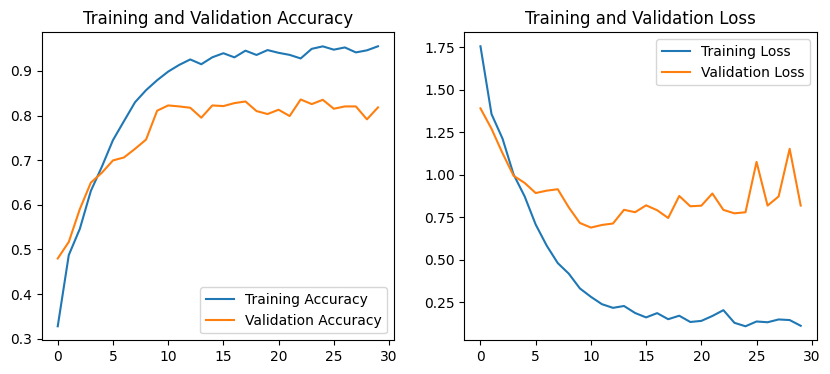

In [50]:
# visualising the results
visualise(history3)

__Findings:__ Accuracy of training and validation has been increased significantly due to rescaling and class imbalance handling. The model is not overfitting, nor underfitting. This model can be used as final model.